<a href="https://colab.research.google.com/github/gustavohroos/treinamento-h2ia/blob/main/MLP/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from scipy.special import xlogy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import trange

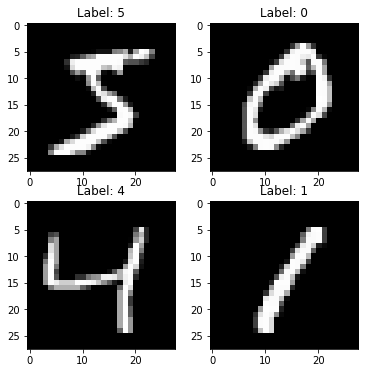

In [2]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    X_train = X_train.reshape([X_train.shape[0], -1])
    X_val = X_val.reshape([X_val.shape[0], -1])
    X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test
    
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [3]:
class Layer:
    def forward(self, input):
        return input

    def backward(self, input, grad_output):
        num_units = input.shape[1]
        
        d_layer_d_input = np.identity(num_units)
        
        return np.dot(grad_output, d_layer_d_input)

In [4]:
class ReLU(Layer):
    def forward(self, input):
        return np.maximum(input, 0)

    def backward(self, input, grad_output):
        return grad_output * (input > 0)

In [5]:
class Dense(Layer):
    def __init__(self, n_inputs, n_outputs, final_layer=False, learning_rate=0.1):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0,
                                        scale=np.sqrt(2/(n_inputs+n_outputs)),
                                        size=(n_inputs, n_outputs))
        
    def forward(self, input):
        return np.dot(input, self.weights)

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(input.T, grad_output)

        assert grad_weights.shape == self.weights.shape

        self.weights = self.weights - self.learning_rate * grad_weights

        return grad_input


In [6]:
def softmax_crossentropy_with_logits(logits, target):
    logits_for_answers = logits[np.arange(len(logits)), target]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits, target):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), target] = 1

    softmax = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

In [7]:
class MLP:

    def __init__(self):
        self.network = []

    def add_layer(self, layer, hidden=True):
        self.network.append(layer)
        if hidden: self.network.append(ReLU())
        
    def forward(self, X):
        activations = []
        input = X

        for layer in self.network:
            activations.append(layer.forward(input))
            input = activations[-1]

        assert len(activations) == len(self.network)

        return activations

    def predict(self, X):
        logits = self.forward(X)[-1]
        return np.argmax(logits, axis=-1)

    def fit(self, X, y):          

        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations
        logits = layer_activations[-1]

        self.loss = softmax_crossentropy_with_logits(logits, y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

        for layer_index in range(len(self.network))[::-1]:
            layer = self.network[layer_index]

            loss_grad = layer.backward(layer_inputs[layer_index], loss_grad)
        
        return self.loss


    def print_layers(self):
        count = 0
        count_layer = 1
        for index, layer in enumerate(self.network):
            if count%2 == 0: 
                print(f'Layer {count_layer} shape: {layer.weights.shape}')
                count_layer += 1
            count +=1
            


In [8]:
model = MLP()
model.add_layer(Dense(X_train.shape[1], 100))
model.add_layer(Dense(100, 100))
model.add_layer(Dense(100, 10), hidden=False)
model.print_layers()

Layer 1 shape: (784, 100)
Layer 2 shape: (100, 100)
Layer 3 shape: (100, 10)


In [9]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    
    if shuffle: indices = np.random.permutation(len(inputs))
    
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle: excerpt = indices[start_idx:start_idx + batchsize]
        else: excerpt = slice(start_idx, start_idx + batchsize)
        
        yield inputs[excerpt], targets[excerpt]
def train_epochs(X_train, y_train, model, X_val, y_val):
  train_log = []
  val_log = []
  for epoch in range(25):
      for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
          model.fit(x_batch,y_batch)
      train_log.append(np.mean(model.predict(X_train)==y_train))
      val_log.append(np.mean(model.predict(X_val)==y_val))
      print("Epoch",epoch)
      print("Train accuracy:",train_log[-1])
      print("Val accuracy:",val_log[-1])
  return train_log, val_log

In [10]:
train_log, val_log = train_epochs(X_train, y_train, model, X_val, y_val)

100%|██████████| 1562/1562 [00:08<00:00, 186.85it/s]


Epoch 0
Train accuracy: 0.95238
Val accuracy: 0.9537


100%|██████████| 1562/1562 [00:08<00:00, 173.73it/s]


Epoch 1
Train accuracy: 0.97436
Val accuracy: 0.9719


100%|██████████| 1562/1562 [00:03<00:00, 476.31it/s]


Epoch 2
Train accuracy: 0.98006
Val accuracy: 0.9714


100%|██████████| 1562/1562 [00:03<00:00, 469.18it/s]


Epoch 3
Train accuracy: 0.9849
Val accuracy: 0.9749


100%|██████████| 1562/1562 [00:03<00:00, 476.59it/s]


Epoch 4
Train accuracy: 0.98818
Val accuracy: 0.9749


100%|██████████| 1562/1562 [00:06<00:00, 245.69it/s]


Epoch 5
Train accuracy: 0.9917
Val accuracy: 0.9775


100%|██████████| 1562/1562 [00:04<00:00, 327.11it/s]


Epoch 6
Train accuracy: 0.9922
Val accuracy: 0.976


100%|██████████| 1562/1562 [00:03<00:00, 453.14it/s]


Epoch 7
Train accuracy: 0.99496
Val accuracy: 0.9789


100%|██████████| 1562/1562 [00:03<00:00, 471.03it/s]


Epoch 8
Train accuracy: 0.99464
Val accuracy: 0.9771


100%|██████████| 1562/1562 [00:03<00:00, 470.55it/s]


Epoch 9
Train accuracy: 0.99708
Val accuracy: 0.9783


100%|██████████| 1562/1562 [00:03<00:00, 475.06it/s]


Epoch 10
Train accuracy: 0.99638
Val accuracy: 0.9782


100%|██████████| 1562/1562 [00:03<00:00, 471.04it/s]


Epoch 11
Train accuracy: 0.99532
Val accuracy: 0.9752


100%|██████████| 1562/1562 [00:03<00:00, 467.19it/s]


Epoch 12
Train accuracy: 0.99824
Val accuracy: 0.9798


100%|██████████| 1562/1562 [00:03<00:00, 470.33it/s]


Epoch 13
Train accuracy: 0.99884
Val accuracy: 0.9786


100%|██████████| 1562/1562 [00:03<00:00, 473.81it/s]


Epoch 14
Train accuracy: 0.99922
Val accuracy: 0.9795


100%|██████████| 1562/1562 [00:07<00:00, 216.97it/s]


Epoch 15
Train accuracy: 0.99904
Val accuracy: 0.9782


100%|██████████| 1562/1562 [00:06<00:00, 245.37it/s]


Epoch 16
Train accuracy: 0.99988
Val accuracy: 0.9803


100%|██████████| 1562/1562 [00:09<00:00, 168.65it/s]


Epoch 17
Train accuracy: 1.0
Val accuracy: 0.9802


100%|██████████| 1562/1562 [00:06<00:00, 249.73it/s]


Epoch 18
Train accuracy: 1.0
Val accuracy: 0.98


100%|██████████| 1562/1562 [00:03<00:00, 464.86it/s]


Epoch 19
Train accuracy: 1.0
Val accuracy: 0.9803


100%|██████████| 1562/1562 [00:04<00:00, 372.36it/s]


Epoch 20
Train accuracy: 1.0
Val accuracy: 0.9808


100%|██████████| 1562/1562 [00:11<00:00, 136.60it/s]


Epoch 21
Train accuracy: 1.0
Val accuracy: 0.9802


100%|██████████| 1562/1562 [00:03<00:00, 452.90it/s]


Epoch 22
Train accuracy: 1.0
Val accuracy: 0.9806


100%|██████████| 1562/1562 [00:03<00:00, 465.18it/s]


Epoch 23
Train accuracy: 1.0
Val accuracy: 0.9803


100%|██████████| 1562/1562 [00:03<00:00, 469.35it/s]


Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9801


Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9801


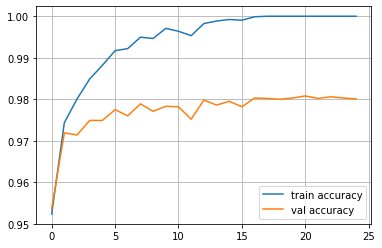

In [11]:
print("Epoch",24)
print("Train accuracy:",train_log[-1])
print("Val accuracy:",val_log[-1])
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [12]:
def plot_predictions(data, target, prediction, n_plots=8,figsize=[15,15]):
  plt.figure(figsize=figsize)
  for i in range(n_plots):
      plt.subplot(n_plots/2, n_plots/2, i+1)
      plt.title(f'Target: {target[i]}   Predicted: {prediction[i]}')
      plt.imshow(data[i].reshape([28,28]),cmap='gray');

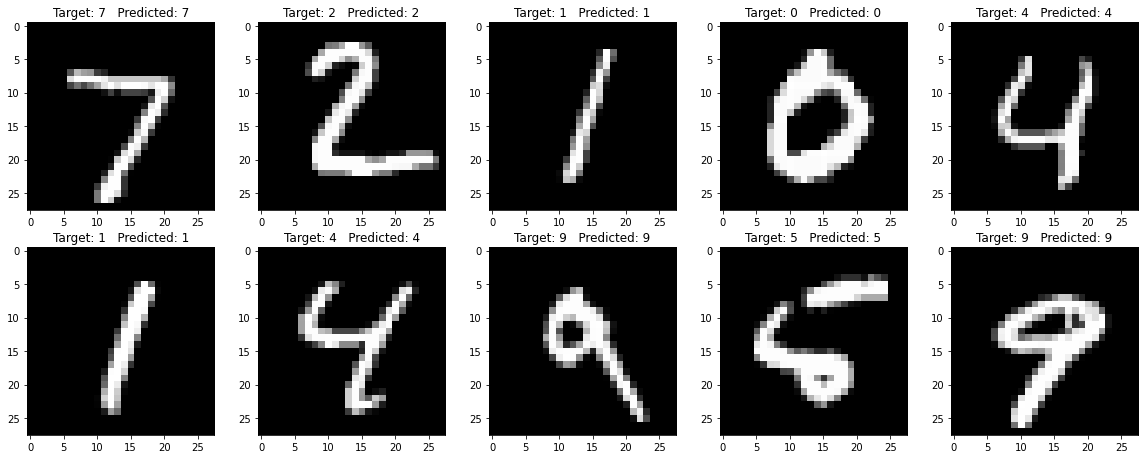

In [13]:
prediction = model.predict(X_test)
plot_predictions(X_test, y_test, prediction, n_plots=10, figsize=[20,20])

In [15]:
print(f'Final accuracy w/ X_test: {np.mean(prediction==y_test)}')

Final accuracy w/ X_test: 0.9813
